In [50]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from data.data_handler import SimpleDataset, CondDataset
from models.layers import Reshape
from torch import optim
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
from scipy.stats.mstats import gmean
import torch.distributions as td
from trainer import Trainer
from cond_trainer import CondTrainer
from torchviz import make_dot

In [51]:
data_dir = "C:/Users/Phili/Documents/exjobb/data/"
data = pd.read_csv(data_dir + "nusat2.csv")
data = data.dropna()
print(len(data))
idx = np.random.choice(np.arange(len(data)), 2000, replace=False)
data = data.iloc[idx]
#data[data.iloc[:, :120].abs() > 0.3] = np.nan 
data = data.dropna()
print(len(data))
t_df = data[["t"]]
y_df = data[["y"]]
sec_df = data[["sector"]]
X = data.iloc[:, :120]
# X[X.abs() > 0.5] = np.nan
# X = X.dropna()
X = (1.0 + X.T).cumprod().T.values
labels, levels = pd.factorize(sec_df.iloc[:,0])
sec_df.loc[:,"labels"] = labels
t = t_df.values
y = y_df.values
sec = sec_df.labels.values
X_train, X_test, y_train, y_test, s_train, s_test, t_train, t_test = train_test_split(X, y, sec, t, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

14401
2000


C:\Users\Phili\Anaconda3\lib\site-packages\pandas\core\indexing.py:376: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Phili\Anaconda3\lib\site-packages\pandas\core\indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [52]:

train_data = SimpleDataset(torch.from_numpy(X_train), torch.from_numpy(y_train))
test_data = SimpleDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))


In [53]:
X_test.max(axis=0)

array([5.33802987, 4.72607221, 5.55035364, 4.48851761, 4.48531841,
       5.25897675, 5.33046274, 4.8994549 , 4.05855394, 4.06093035,
       4.6824511 , 3.61917462, 4.04260807, 4.32583651, 4.77292292,
       4.13038325, 4.30465452, 5.42761095, 4.35988168, 4.68308985,
       4.35946292, 4.02480892, 4.40173905, 4.05010514, 3.79129457,
       4.29260795, 4.23130548, 4.78641098, 5.81017688, 4.92798731,
       5.93454797, 7.09301501, 7.00719886, 7.13610579, 7.21483016,
       6.44820164, 5.50596979, 5.14388943, 4.66979218, 4.42301313,
       3.54571263, 3.55823938, 3.61240209, 4.1946653 , 4.79339796,
       4.58106823, 4.72833428, 4.79315436, 4.34132475, 4.4361552 ,
       5.8011569 , 5.95491341, 5.33861571, 6.28868815, 5.43450149,
       4.57601733, 4.00208106, 3.69401634, 4.02589621, 3.90930613,
       3.84899379, 3.8058615 , 3.5465662 , 3.22360722, 3.06687818,
       3.36037674, 3.47684041, 3.47518748, 3.40534557, 3.26443522,
       3.22775791, 3.26750078, 3.23143611, 3.55570563, 3.34691

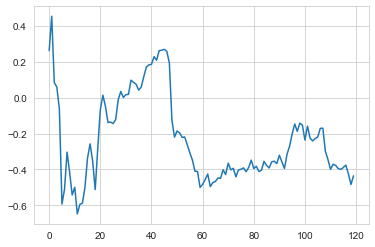

In [54]:
i = np.random.randint(0, len(train_data))
_ = plt.plot(train_data[i][0].detach().numpy())

In [55]:
class Latent(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i, o)
        
        self.elu = nn.ELU()
        
    def _rep(self, mu, log_var):
        eps = torch.randn_like(log_var)
        sigma = torch.exp(0.5 * log_var) + 1e-4
        return mu + eps*sigma
    
    def forward(self, x):
        mu = self.mu(x)
        #mu = self.elu(mu)
        log_var = self.log_var(x)
        #log_var = self.elu(log_var)
        z = self._rep(mu, log_var)
        return z, mu, log_var

class Dense(nn.Module):
    def __init__(self, i,o):
        super().__init__()
        self.l = nn.Sequential(
            nn.Linear(i, o),
            #nn.BatchNorm1d(o),
            nn.ELU()
        )
    def forward(self, x):
        return self.l(x)
    
class Normal(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i,o)
    
    def forward(self, x):
        mu = self.mu(x)
        log_var = self.log_var(x)
        sigma = torch.exp(0.5 * log_var) + 1e-4
        return td.Normal(mu, sigma)
    
class ST(nn.Module):
    def __init__(self, i, o):
        super().__init__()
        self.df = nn.Sequential(
            nn.Linear(i, o),
            #nn.Softmax()
        )
        self.mu = nn.Linear(i, o)
        self.log_var = nn.Linear(i, o)
    
    def forward(self, x):
        df = self.df(x)
        df = torch.exp(0.5 * df)
        mu = self.mu(x)
        log_var = self.log_var(x)
        sigma = torch.exp(0.5 * log_var)
        return td.StudentT(df, mu, sigma)

In [56]:
class VAE(nn.Module):
    def __init__(self, T, n_z):
        super().__init__()
        
        self.mse = nn.MSELoss(reduction="sum")
        
        self.enc = nn.Sequential(
            Dense(T, 64),
            Dense(64, 64),
            Dense(64, 16),
            Latent(16, n_z)
        )
        self.dec = nn.Sequential(
            Dense(n_z, 16),
            Dense(16, 64),
            Dense(64, 64),
            Normal(64, T)
        )
        
    def encode(self, x):
        return self.enc(x)
    
    def decode(self, z):
        return self.dec(z)
    
    def _dkl(self, mu, log_var):
        alpha = 1.
        vega =1.
        dkl = 0.5 * torch.sum(alpha * mu.pow(2) + log_var.exp() -1 -vega*log_var)
        return dkl
    
    def forward(self, x, beta = 1.0):
        z, mu, log_var = self.enc(x)
        dkl = self._dkl(mu, log_var)
        gen_x = self.dec(z)
        #rcl = self.mse(gen_x, x)
        rcl = -gen_x.log_prob(x).sum()
        loss = rcl + beta*dkl
        
        return gen_x, loss

In [87]:
n_z = 16
vae = VAE(120, n_z)
t = Trainer(vae, train_data, test_data)


In [88]:
losses = t.fit(200, burn_in=0)

Epoch: 0, Train Loss: 150.67, Test Loss:  129.13
Epoch: 10, Train Loss: 35.43, Test Loss:  40.46
Epoch: 20, Train Loss: 19.25, Test Loss:  27.03
Epoch: 30, Train Loss: 3.23, Test Loss:  13.59
Epoch: 40, Train Loss: -8.95, Test Loss:  3.37
Epoch: 50, Train Loss: -12.87, Test Loss: -4.23
Epoch: 60, Train Loss: -18.82, Test Loss: -9.30
Epoch: 70, Train Loss: -22.88, Test Loss: -12.69
Epoch: 80, Train Loss: -24.75, Test Loss: -16.42
Epoch: 90, Train Loss: -26.51, Test Loss: -16.93
Epoch: 100, Train Loss: -26.67, Test Loss: -20.48
Epoch: 110, Train Loss: -32.43, Test Loss: -23.12
Epoch: 120, Train Loss: -34.12, Test Loss: -23.25
Epoch: 130, Train Loss: -34.25, Test Loss: -23.33
Epoch: 140, Train Loss: -35.95, Test Loss: -23.83
Epoch: 150, Train Loss: -35.99, Test Loss: -23.26
Epoch: 160, Train Loss: -36.55, Test Loss: -24.86
Epoch: 170, Train Loss: -36.58, Test Loss: -25.01
Epoch: 180, Train Loss: -37.83, Test Loss: -25.37
Epoch: 190, Train Loss: -38.64, Test Loss: -25.19


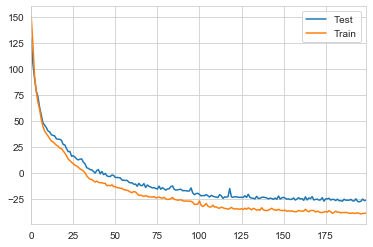

In [89]:
losses[losses < 1000].plot()


In [90]:
X, t = train_data[:500]
z, mu, log_var = vae.encode(X)
zz = pd.DataFrame(mu.detach().numpy(), columns = ["x", "y"])
zz["t"] = t.detach().numpy()
fig, ax = plt.subplots()
for name, grp in zz.groupby("t"):
    ax.plot(grp.x, grp.y, marker='o', linestyle='', ms=3, label=name, alpha=1)
ax.legend()
plt.show()

ValueError: Shape of passed values is (500, 16), indices imply (500, 2)

In [91]:
z.mean(dim=0), z.std(dim=0)

(tensor([-0.0741,  0.0484,  0.0401,  0.0164,  0.0576, -0.0188,  0.0441, -0.0232,
          0.0138,  0.0408, -0.0075,  0.0021,  0.0356, -0.0232, -0.0420,  0.0345],
        grad_fn=<MeanBackward1>),
 tensor([0.9652, 1.0637, 1.0093, 1.0263, 0.9342, 0.9525, 0.9629, 0.9604, 1.0271,
         0.9470, 0.9639, 1.1968, 1.0036, 0.9683, 0.9759, 0.9902],
        grad_fn=<StdBackward1>))

In [92]:
vae.eval()

VAE(
  (mse): MSELoss()
  (enc): Sequential(
    (0): Dense(
      (l): Sequential(
        (0): Linear(in_features=120, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (1): Dense(
      (l): Sequential(
        (0): Linear(in_features=64, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (2): Dense(
      (l): Sequential(
        (0): Linear(in_features=64, out_features=16, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (3): Latent(
      (mu): Linear(in_features=16, out_features=16, bias=True)
      (log_var): Linear(in_features=16, out_features=16, bias=True)
      (elu): ELU(alpha=1.0)
    )
  )
  (dec): Sequential(
    (0): Dense(
      (l): Sequential(
        (0): Linear(in_features=16, out_features=16, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (1): Dense(
      (l): Sequential(
        (0): Linear(in_features=16, out_features=64, bias=True)
        (1): ELU(alpha=1.0)
      )
    )
    (2): Dense(
      

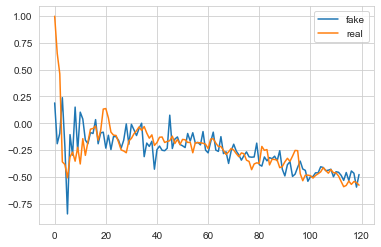

In [99]:
i = np.random.randint(0, len(train_data))
x, y = train_data[i:(i+1)]
z, mu, log_var = vae.encode(x)
gen_x = vae.decode(z)
_ = plt.plot(gen_x.sample().detach().numpy()[0], label="fake")
_ = plt.plot(x.detach().numpy()[0], label="real")
plt.legend()

In [100]:
def grad(x, dist):
    mu = dist.mean
    sigma = dist.scale
    grad = (x - mu) / (sigma.pow(2) + 1e-4)
    return grad

def gradm(x, dist):
    return x - dist

def sgd(x, vae, N=200, alpha=1, eps = 1):
    z_list = []
    x_list = []
    x_list.append(x.unsqueeze(0))
    z, mu, log_var = vae.encode(x)
    z_list.append(mu.unsqueeze(1))
    for i in range(N):
        #eps = eps / np.sqrt(i+1)
        x_z = x + np.sqrt(eps / np.sqrt(i+1)) * torch.randn_like(x)
        #print(x_z.shape, "x")
        z, mu, log_var = vae.encode(x_z)
        dist = vae.decode(z)
        z_list.append(mu.unsqueeze(1))
        g = grad(x_z, dist)
        #print(g.shape, "G")
        x = x - alpha * g / np.sqrt(i+1)
        x_list.append(x.unsqueeze(0))
    return torch.cat(z_list, 1), torch.cat(x_list)

def adam(x, vae, N, alpha):
    z_list = []
    x_list = []
    beta_1 = 0.9
    beta_2 = 0.999
    eps = 1e-8
    m = 0
    v = 0
    
    z, mu, log_var = vae.encode(x)
    z_list.append(mu.unsqueeze(1))
    x_list.append(x.unsqueeze(0))
    
    
    for i in range(N):
        z, mu, log_var = vae.encode(x)
        gen_x = vae.decode(z)
        g = grad(x, gen_x)
        m = beta_1*m + (1-beta_1)*g
        v = beta_2*v + (1-beta_2)*g.pow(2)
        m_hat = m/(1-beta_1**(i+1))
        v_hat = v/(1-beta_2**(i+1))
        x = x - alpha*m_hat/(torch.sqrt(v_hat)+eps)
        z_list.append(mu.unsqueeze(1))
        x_list.append(x.unsqueeze(0))
    return torch.cat(z_list, 1), torch.cat(x_list)

In [101]:
x,t = train_data[4:5]
z_list, x_list = sgd(x,vae, 2000, 0.01, 1)

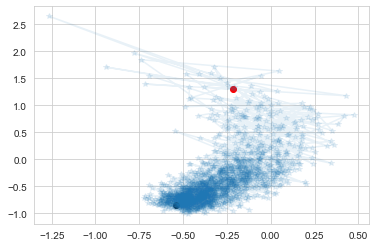

In [102]:
zz = z_list.detach().numpy()
_ = plt.plot(zz[0,:,0], zz[0,:,1],"*-" ,alpha=0.1)
_ = plt.scatter(zz[0,0,0], zz[0,0,1], c="r")
_ = plt.scatter(zz[0,-1,0], zz[0,-1,1], c="black")

In [105]:
print(len(train_data))
with torch.no_grad():
    idx = np.random.choice(np.arange(len(train_data)), 800, replace=False)
    X, t = train_data[idx]
    zz, xx = sgd(X,vae, 2000, 0.001, 1)
    

1600


In [70]:

zz_df = pd.DataFrame(zz[:,-1].detach().numpy(), columns = ["x", "y"])
zz_df["class"] = t.detach().numpy()
zz_first_df = pd.DataFrame(zz[:,0].detach().numpy(), columns = ["x", "y"])
zz_first_df["class"] = t.detach().numpy()

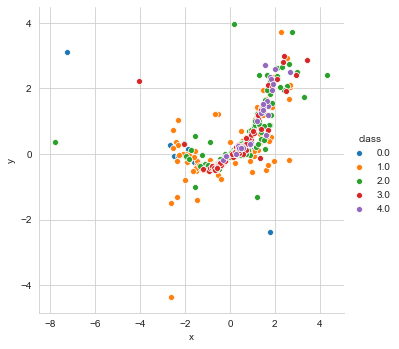

In [71]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="class", data=zz_df, height=5)

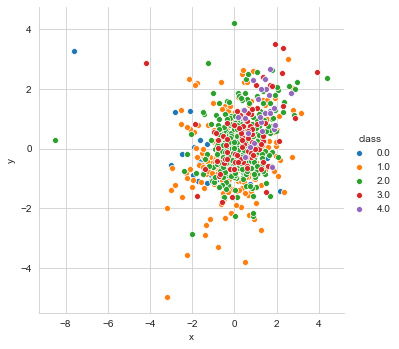

In [72]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="class", data=zz_first_df, height=5)

In [73]:
from sklearn.cluster import KMeans, DBSCAN

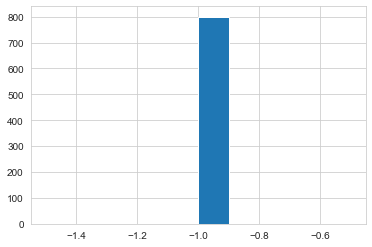

In [108]:
x = xx.detach().numpy()
last = x[-1]
last = last[~np.isnan(last).any(axis=1)]
x_df = pd.DataFrame(scaler.inverse_transform(x[0]))
kk = DBSCAN().fit_predict(x[-1])
x_df["cluster"] = kk
zz_df["cluster"] = kk
_ = plt.hist(kk)


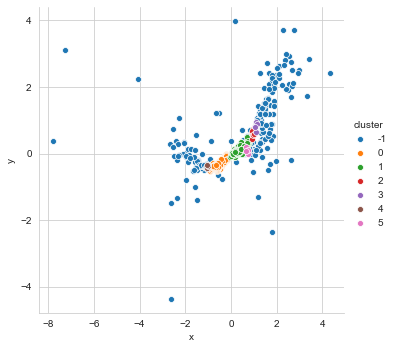

In [80]:
sns.pairplot(x_vars = "x", y_vars = "y", hue="cluster", data=zz_df, height=5)

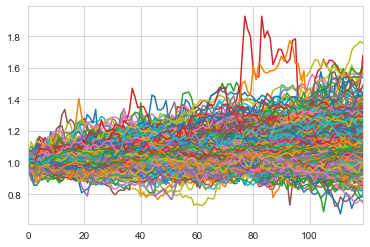

In [81]:
x_df[x_df.cluster == 0].drop("cluster", axis=1).T.plot(legend=False)


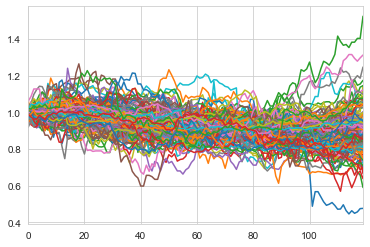

In [82]:
x_df[x_df.cluster == 1].drop("cluster", axis=1).T.plot(legend=False)


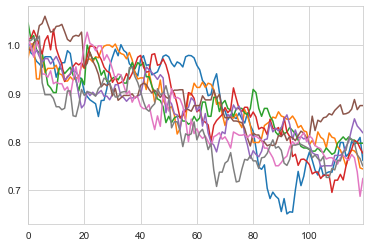

In [83]:
x_df[x_df.cluster == 2].drop("cluster", axis=1).T.plot(legend=False)


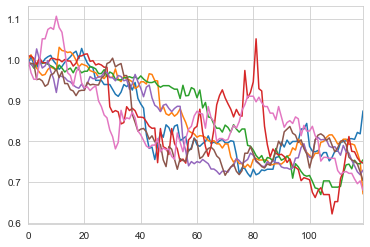

In [84]:
x_df[x_df.cluster == 3].drop("cluster", axis=1).T.plot(legend=False)


In [ ]:
x_df[x_df.cluster == 4].drop("cluster", axis=1).T.mean(axis=1).plot(kind="bar",legend=False)


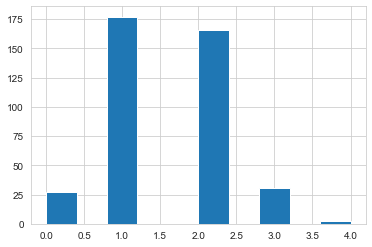

In [85]:
t_df = pd.DataFrame(t.detach().numpy(), columns = ["label"])
t_df["cluster"] = kk
_ = plt.hist(t_df[t_df.cluster == 0].label)

In [86]:
t_df

,label,cluster
0,1.0,0
1,2.0,0
2,2.0,-1
3,1.0,0
4,1.0,-1
...,...,...
795,1.0,-1
796,0.0,0
797,2.0,0
798,2.0,-1
